# **Enhancing 6D Object Pose Estimation**

**TA:** Stephany Ortuno Chanelo (stephany.ortuno@polito.it)

**TASK OVERVIEW**
This project aims to explore and implement advanced techniques for 6D pose estimation using RGB-D images. The goal is to build an end-to-end pipeline for estimating the 6D pose of objects by initially replicating a model that uses just RGB images. The pipeline will then be enhanced by incorporating depth information to improve accuracy in the pose predictions. You will adapt and implement the methodology, starting from pose prediction and then extend the model with your own innovative improvements.


In [ ]:
# Go to directory
!mkdir -p datasets/linemod/
%cd datasets/linemod/

/content/datasets/linemod


In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Unzip Dataset

from google.colab import drive
import shutil
import os

# 2. Define Paths
# Assuming you saved the file in the main folder of your Drive ('My Drive')
drive_path = '/content/drive/MyDrive/Linemod_preprocessed.zip'
colab_path = '/content/Linemod_preprocessed.zip'

# 3. Copy file from Drive to Colab Local Runtime
# This is usually very fast (seconds)
if os.path.exists(drive_path):
    print(f"Found file at {drive_path}. Copying to local runtime...")
    shutil.copy(drive_path, colab_path)
    print("Copy complete!")

    # 4. Unzip
    print("Unzipping dataset...")
    !unzip -q {colab_path}  # -q means "quiet" (hides the long list of files)
    print("Unzip complete! Dataset is ready.")
else:
    print(f"Error: Could not find '{drive_path}'.")
    print("Make sure you renamed the file correctly in your Google Drive.")

Found file at /content/drive/MyDrive/Linemod_preprocessed.zip. Copying to local runtime...
Copy complete!
Unzipping dataset...
Unzip complete! Dataset is ready.


In [ ]:
! pip install ultralytics pcl trimesh pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.4/740.4 kB 59.5 MB/s eta 0:00:00
  Created wheel for pcl: filename=pcl-0.0.0.post1-py3-none-any.whl size=1690 sha256=de770de7d8e911e2abfb8b74e7d76146dd007d07932511c719cb8502abcc0986
  Stored in directory: /root/.cache/pip/wheels/70/63/a5/01bf8671f269ba8a6ae44ef331b9a99201f8cf287b1a031c5f
Successfully built pcl


In [ ]:
import os
import yaml
import torch
import glob
import random
import math
import cv2
import time

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms

from ultralytics import YOLO
from pathlib import Path

from collections import defaultdict
from scipy.spatial.transform import Rotation as R

from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import torch.nn.functional as F
import shutil

from concurrent.futures import ThreadPoolExecutor, as_completed

import torch.optim as optim

import trimesh
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import metrics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Directory Setup

# Define the root and structure
base_dir = "/content/drive/MyDrive/6DAML"
structure = {
    "baseline": [],
    "extension": ["RT_LateGlobalFusion", "T_CNN", "R_Fusion"]
}

# Create directories
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    print(f"Created root directory: {base_dir}")

for main_folder, subfolders in structure.items():
    main_path = os.path.join(base_dir, main_folder)
    os.makedirs(main_path, exist_ok=True)

    for sub in subfolders:
        sub_path = os.path.join(main_path, sub)
        os.makedirs(sub_path, exist_ok=True)
        print(f"Verified/Created: {sub_path}")

In [ ]:
# YOLO Data Pre-Processing

# --- CONFIGURATION ---
DATASET_ROOT = "/content/datasets/linemod/Linemod_preprocessed/data"

# Standard LineMod ID to Name mapping
LINEMOD_ID_MAP = {
    '01': 'ape', '02': 'benchvise', '04': 'cam', '05': 'can',
    '06': 'cat', '08': 'driller', '09': 'duck', '10': 'eggbox',
    '11': 'glue', '12': 'holepuncher', '13': 'iron', '14': 'lamp', '15': 'phone'
}

def process_dataset_fast():
    if not os.path.exists(DATASET_ROOT):
        print(f"Error: Path '{DATASET_ROOT}' not found.")
        return

    print(f"Scanning for classes in: {DATASET_ROOT}")

    # 1. Identify Valid Folders
    available_folders = [f for f in sorted(os.listdir(DATASET_ROOT))
                         if f in LINEMOD_ID_MAP and os.path.isdir(os.path.join(DATASET_ROOT, f))]

    if not available_folders:
        print("No valid class folders found!")
        return

    # Map Folder Name ('01') -> YOLO ID (0, 1, 2...)
    folder_to_yolo_id = {folder: i for i, folder in enumerate(available_folders)}

    # 2. Process gt.yml -> YOLO Labels
    for folder_name in available_folders:
        yolo_id = folder_to_yolo_id[folder_name]
        real_name = LINEMOD_ID_MAP[folder_name]

        # Helper to convert folder string '02' to integer 2 for comparison with gt.yml
        target_obj_id = int(folder_name)

        folder_path = os.path.join(DATASET_ROOT, folder_name)
        gt_path = os.path.join(folder_path, "gt.yml")
        rgb_dir = os.path.join(folder_path, "rgb")

        print(f"Processing '{real_name}' (ID: {yolo_id}) using gt.yml...")

        if not os.path.exists(gt_path):
            print(f"  Warning: gt.yml not found in {folder_name}. Skipping.")
            continue

        # Get Image Dimensions (Open one image to check size)
        sample_imgs = glob.glob(os.path.join(rgb_dir, "*.png")) + glob.glob(os.path.join(rgb_dir, "*.jpg"))
        if not sample_imgs:
            print(f"  Warning: No images found in {rgb_dir}")
            continue

        img = cv2.imread(sample_imgs[0])
        img_h, img_w = img.shape[:2]

        # Load Metadata
        with open(gt_path, 'r') as f:
            gt_data = yaml.safe_load(f)

        count = 0
        for img_id_int, anns in gt_data.items():
            file_id = f"{img_id_int:04d}"

            # Search through all annotations for this image to find the one matching our class
            target_ann = None
            for annotation in anns:
                if annotation['obj_id'] == target_obj_id:
                    target_ann = annotation
                    break

            # If the specific object (e.g., Benchvise) isn't in this image, skip the image
            if target_ann is None:
                continue

            x, y, w, h = target_ann['obj_bb']

            # Normalize for YOLO: [x_center, y_center, width, height]
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            w_norm = w / img_w
            h_norm = h / img_h

            # Write to .txt file in the RGB folder
            label_path = os.path.join(rgb_dir, f"{file_id}.txt")

            with open(label_path, 'w') as f_out:
                f_out.write(f"{yolo_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

            count += 1

        print(f"  -> Generated {count} labels in 'rgb' folder.")

    # 3. Create linemod.yaml automatically
    yaml_content = {
        'path': os.path.abspath(DATASET_ROOT),
        'train': 'train.txt',
        'val': 'val.txt',
        'test': 'test.txt',
        'names': {i: LINEMOD_ID_MAP[folder] for i, folder in enumerate(available_folders)}
    }

    with open('linemod.yaml', 'w') as f:
        yaml.dump(yaml_content, f)

    print("\nSuccess! 'linemod.yaml' created.")
    print("Class mapping:", yaml_content['names'])

process_dataset_fast()

Scanning for classes in: /content/datasets/linemod/Linemod_preprocessed/data
Processing 'ape' (ID: 0) using gt.yml...
  -> Generated 1236 labels in 'rgb' folder.
Processing 'benchvise' (ID: 1) using gt.yml...
  -> Generated 1214 labels in 'rgb' folder.
Processing 'cam' (ID: 2) using gt.yml...
  -> Generated 1201 labels in 'rgb' folder.
Processing 'can' (ID: 3) using gt.yml...
  -> Generated 1196 labels in 'rgb' folder.
Processing 'cat' (ID: 4) using gt.yml...
  -> Generated 1179 labels in 'rgb' folder.
Processing 'driller' (ID: 5) using gt.yml...
  -> Generated 1188 labels in 'rgb' folder.
Processing 'duck' (ID: 6) using gt.yml...
  -> Generated 1254 labels in 'rgb' folder.
Processing 'eggbox' (ID: 7) using gt.yml...
  -> Generated 1253 labels in 'rgb' folder.
Processing 'glue' (ID: 8) using gt.yml...
  -> Generated 1220 labels in 'rgb' folder.
Processing 'holepuncher' (ID: 9) using gt.yml...
  -> Generated 1237 labels in 'rgb' folder.
Processing 'iron' (ID: 10) using gt.yml...
  -> Ge

In [ ]:
# Data Splitting (train-val-test.txt)

# CONFIGURATION
DATASET_ROOT = "./datasets/linemod/Linemod_preprocessed/data"
OUTPUT_DIR = "."

def create_scientific_split():
    all_images = []

    # 1. Collect ALL images
    valid_folders = [f for f in sorted(os.listdir(DATASET_ROOT))
                     if os.path.isdir(os.path.join(DATASET_ROOT, f)) and f.isdigit()]

    for folder in valid_folders:
        rgb_path = os.path.join(DATASET_ROOT, folder, "rgb")
        if os.path.exists(rgb_path):
            for filename in os.listdir(rgb_path):
                if filename.endswith(".png") or filename.endswith(".jpg"):
                    full_path = os.path.abspath(os.path.join(rgb_path, filename))
                    all_images.append(full_path)

    # 2. Shuffle and Split (60% / 20% / 20%)
    total_images = len(all_images)
    random.seed(42)
    random.shuffle(all_images)

    # Calculate indices
    train_end = int(total_images * 0.6)
    val_end = int(total_images * 0.8) # 60% + 20% = 80%

    train_imgs = all_images[:train_end]
    val_imgs   = all_images[train_end:val_end] # The slice from 60% to 80%
    test_imgs  = all_images[val_end:]          # The slice from 80% to 100%

    # 3. Write to THREE files
    with open(os.path.join(OUTPUT_DIR, "train.txt"), 'w') as f:
        f.write('\n'.join(train_imgs))

    with open(os.path.join(OUTPUT_DIR, "val.txt"), 'w') as f:
        f.write('\n'.join(val_imgs))

    with open(os.path.join(OUTPUT_DIR, "test.txt"), 'w') as f:
        f.write('\n'.join(test_imgs))

    print(f"Split Complete:")
    print(f"  Train: {len(train_imgs)} (60%)")
    print(f"  Val:   {len(val_imgs)} (20%)")
    print(f"  Test:  {len(test_imgs)} (20%)")

    # 4. Update linemod.yaml to use all three
    try:
        if os.path.exists('linemod.yaml'):
            with open('linemod.yaml', 'r') as f:
                config = yaml.safe_load(f)
        else:
            config = {'names': {}}

        config['train'] = os.path.abspath("train.txt")
        config['val'] = os.path.abspath("val.txt")   # YOLO uses this during training
        config['test'] = os.path.abspath("test.txt") # Purely for your final eval

        with open('linemod.yaml', 'w') as f:
            yaml.dump(config, f)
        print("Updated 'linemod.yaml' correctly.")

    except Exception as e:
        print(f"Warning: Could not update linemod.yaml: {e}")

create_scientific_split()

In [ ]:
# YOLO Training

DRIVE_SAVE_PATH = '/content/drive/MyDrive/6DAML/yolo/yolo_60-20-20_epc50'

model_yolo = YOLO('yolov8n.pt')

results = model_yolo.train(
    data='linemod.yaml',
    epochs=50,
    imgsz=640,
    project=DRIVE_SAVE_PATH,
    name='train_yolo_60_20_20_epc50',     # Name of the sub-folder
    verbose=True
)

In [ ]:
# YOLO Prediction

# CONFIGURATION
DRIVE_SAVE_PATH = '/content/drive/MyDrive/6DAML/yolo/yolo_60-20-20_epc50'
TRAIN_RUN_NAME = 'train_yolo_60_20_20_epc50'

# Construct the path to your trained 'best.pt' weights
model_weights = os.path.join(DRIVE_SAVE_PATH, TRAIN_RUN_NAME, 'weights', 'best.pt')
output_base_dir = '/content/yolo/predictions_test_set_epc50'
# output_base_dir = os.path.join(DRIVE_SAVE_PATH, 'predictions_test_set_epc50')

if not os.path.exists(model_weights):
    print(f"Error: Model weights not found at {model_weights}")
else:
    print(f"Loading model from: {model_weights}")
    model = YOLO(model_weights)

    # 1. Read the image paths from test.txt
    with open('/content/datasets/linemod/Linemod_preprocessed/data/test.txt', 'r') as f:
        image_paths = [line.strip() for line in f.readlines() if line.strip()]

    print(f"Processing {len(image_paths)} images individually to preserve folder structure...")

    # 2. Iterate through each image path
    for img_path in image_paths:

        p = Path(img_path)
        filename = p.stem
        obj_id = p.parent.parent.name

        save_dir = os.path.join(output_base_dir, obj_id)
        os.makedirs(save_dir, exist_ok=True)

        # 3. Run Prediction on single image
        results = model.predict(
            source=img_path,
            save=False,
            save_txt=False,
            conf=0.5,
            verbose=False
        )

        result = results[0]   # Get the single result object

        # 4. Manually Save TXT
        txt_path = os.path.join(save_dir, f"{filename}.txt")

        with open(txt_path, 'w') as f_out:
            for box in result.boxes:
                x, y, w, h = box.xywhn[0].tolist()
                conf = box.conf[0].item()
                cls = int(box.cls[0].item())

                # Write line: class x y w h conf
                line = f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f} {conf:.6f}\n"
                f_out.write(line)

        # 5. Manually Save Image (Visualisation)
        img_save_path = os.path.join(save_dir, f"{filename}.jpg")
        plotted_img = result.plot() # Returns the image as a BGR numpy array
        cv2.imwrite(img_save_path, plotted_img)

    print("-" * 40)
    print(f"Predictions Complete!")
    print(f"Results separated by object folders in: {output_base_dir}")

Loading model from: /content/drive/MyDrive/6DAML/yolo/yolo_60-20-20_epc50/train_yolo_60_20_20_epc50/weights/best.pt
Processing 3160 images individually to preserve folder structure...
----------------------------------------
Predictions Complete!
Results separated by object folders in: /content/yolo/predictions_test_set_epc50


In [ ]:
# YOLO PREDICTIONS UNZIPPING

import os
import zipfile

# --- CONFIGURATION ---
ZIP_PATH = "/content/drive/MyDrive/6DAML/yolo/yolo_60-20-20_epc50.zip"
EXTRACT_TO = "/content/yolo_local_preds"

print(f"Unzipping '{ZIP_PATH}' to '{EXTRACT_TO}'...")

# 1. Unzip the file
if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_TO)
    print(" -> Unzip complete!")
else:
    raise FileNotFoundError(f"Could not find the zip file at: {ZIP_PATH}")

# 2. Automatically find the folder containing the object folders ('01', '02', etc.)
#    This handles cases where the zip creates extra nested folders.
found_dir = None
for root, dirs, files in os.walk(EXTRACT_TO):
    # We look for a known object folder like '01' or '02'
    if '01' in dirs and '02' in dirs:
        found_dir = root
        break

if found_dir:
    YOLO_PREDS_DIR = found_dir
    print("-" * 50)
    print(f"SUCCESS! The text files are located in:")
    print(f"'{YOLO_PREDS_DIR}'")
    print("-" * 50)
    print("Use the line below in your next cell:")
    print(f'YOLO_PREDS_DIR = "{YOLO_PREDS_DIR}"')
else:
    # Fallback: Just use the extract root if structure is weird
    YOLO_PREDS_DIR = EXTRACT_TO
    print(f"Warning: Could not automatically detect object folders. Using root: {YOLO_PREDS_DIR}")

In [ ]:
# TRANSLATION MLP #1: Configuration

# --- CONFIGURATION ---
DATASET_ROOT = "/content/datasets/linemod/Linemod_preprocessed/data"
YOLO_PRED_DIR = "/content/yolo/predictions_test_set_epc50"

# Splits
TRAIN_SPLIT = "train.txt"
VAL_SPLIT = "val.txt"
TEST_SPLIT = "test.txt"

# Camera Intrinsics
FX = 572.4114
FY = 573.57043
CX = 325.2611
CY = 242.04899

# Model Input Size
DEPTH_IMG_SIZE = 112

# --- HYPERPARAMETERS ---
BATCH_SIZE = 64
LR = 0.0002
DROPOUT = 0.2
EPOCHS = 50
WD = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- SAVING CONFIGURATION ---
BASE_SAVE_DIR = "/content/drive/MyDrive/6DAML/extension"
EXP_ID = "T13_60-20-20"

print(f"Running on: {DEVICE}")
print(f"YOLO Source: {YOLO_PRED_DIR}")

Running on: cuda
YOLO Source: /content/yolo/predictions_test_set_epc50


In [ ]:
# TRANSLATION MLP #2: Data Pre-Processing

class LineModDepthDataset(Dataset):
    def __init__(self, root_dir, split_file, input_size=112, yolo_root=None):
        self.root_dir = root_dir
        self.input_size = input_size
        self.yolo_root = yolo_root
        self.samples = []

        # LineMod Constants
        self.IMG_W = 640
        self.IMG_H = 480

        filepath = os.path.join(root_dir, split_file)

        if not os.path.exists(filepath):
            if os.path.exists(split_file):
                filepath = split_file
            else:
                raise FileNotFoundError(f"Split file not found: {filepath}")

        with open(filepath, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]

        print(f"Parsing {len(lines)} lines from {os.path.basename(filepath)}...")
        if self.yolo_root:
            print(f" -> YOLO Mode Enabled. Source: {self.yolo_root}")

        gt_cache = {}

        for line in lines:
            parts = line.split('/')
            try:
                if 'data' in parts:
                    data_idx = parts.index('data')
                    obj_id_str = parts[data_idx + 1]
                else:
                    obj_id_str = parts[-3]

                filename = parts[-1]
                img_id = int(os.path.splitext(filename)[0])
            except (ValueError, IndexError):
                continue

            if obj_id_str not in gt_cache:
                gt_path = os.path.join(root_dir, obj_id_str, "gt.yml")
                if os.path.exists(gt_path):
                    with open(gt_path, 'r') as f:
                        gt_cache[obj_id_str] = yaml.safe_load(f)
                else:
                    gt_cache[obj_id_str] = None

            gt_data = gt_cache[obj_id_str]
            if gt_data is None or img_id not in gt_data:
                continue

            target_obj_id = int(obj_id_str)
            target_ann = None

            for ann in gt_data[img_id]:
                if ann['obj_id'] == target_obj_id:
                    target_ann = ann
                    break

            if target_ann is None: continue

            # -- BENCHVISE FILTER --
            if target_obj_id == 2 and ann['obj_id'] != 2:
                continue

            base_folder = os.path.join(root_dir, obj_id_str)
            depth_path = os.path.join(base_folder, 'depth', f"{img_id:04d}.png")

            if not os.path.exists(depth_path): continue

            self.samples.append({
                'depth_path': depth_path,
                'gt_bbox': target_ann['obj_bb'],
                'cam_t_m2c': target_ann['cam_t_m2c'],
                'obj_id_str': obj_id_str,
                'obj_id': target_obj_id,
                'img_id': img_id
            })

        print(f" -> Done! Loaded {len(self.samples)} samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # 1. Load Depth (16-bit, Millimeters)
        depth_img = cv2.imread(sample['depth_path'], -1)
        if depth_img is None:
            depth_img = np.zeros((self.IMG_H, self.IMG_W), dtype=np.uint16)

        # Convert to Meters for the Input Tensor (loop expects Meters)
        depth_m = depth_img.astype(np.float32) / 1000.0
        H, W = depth_m.shape

        # 2. Determine Bounding Box (YOLO vs GT)
        x, y, w, h = map(int, sample['gt_bbox'])

        if self.yolo_root:
            yolo_file = os.path.join(self.yolo_root, sample['obj_id_str'], f"{sample['img_id']:04d}.txt")
            if os.path.exists(yolo_file):
                try:
                    with open(yolo_file, 'r') as f:
                        content = f.read().strip().split()
                        if len(content) >= 5:
                            cx_n, cy_n, w_n, h_n = map(float, content[1:5])
                            w_pix = w_n * self.IMG_W
                            h_pix = h_n * self.IMG_H
                            cx_pix = cx_n * self.IMG_W
                            cy_pix = cy_n * self.IMG_H
                            x = int(cx_pix - (w_pix / 2))
                            y = int(cy_pix - (h_pix / 2))
                            w = int(w_pix)
                            h = int(h_pix)
                except Exception:
                    pass

        # 3. Crop & Resize
        x = max(0, x); y = max(0, y)
        w = min(w, W - x); h = min(h, H - y)

        if w <= 0 or h <= 0:
            crop = np.zeros((self.input_size, self.input_size), dtype=np.float32)
        else:
            crop = depth_m[y:y+h, x:x+w]

        crop_resized = cv2.resize(crop, (self.input_size, self.input_size), interpolation=cv2.INTER_NEAREST)
        crop_tensor = torch.tensor(crop_resized).unsqueeze(0)

        # 4. Targets
        # We need the full vector for total translation error
        gt_t_vector = torch.tensor(sample['cam_t_m2c'], dtype=torch.float32) # [tx, ty, tz] (mm)

        # We pass the bbox back so we can compute Tx/Ty via Pinhole
        bbox_tensor = torch.tensor([x, y, w, h], dtype=torch.float32)

        return {
            'depth': crop_tensor,
            'gt_t': gt_t_vector,
            'tz_gt': gt_t_vector[2],
            'bbox': bbox_tensor,
            'obj_id': sample['obj_id']
        }


In [ ]:
# TRANSLATION MLP #3: Model Definition

class DepthZPredictor(nn.Module):
    def __init__(self):
        super(DepthZPredictor, self).__init__()

        # Input: 1 Channel (Depth)
        # Architecture: 4 Conv Blocks (Deeper/Wider) -> Flatten -> Larger MLP -> 1 Scalar

        self.features = nn.Sequential(
            # Block 1: 1 -> 64 (Wider start)
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # 112 -> 56

            # Block 2: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # 56 -> 28

            # Block 3: 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # 28 -> 14

            # Block 4: 256 -> 512 (New Extra Layer)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14 -> 7
        )

        # MLP Head
        # Note: Input size = 512 channels * 7 * 7 spatial size = 25,088
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(512, 128),
            nn.ReLU(),

            nn.Linear(128, 1)            # Output: Tz (mm)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x.squeeze(1) # [Batch, 1] -> [Batch]

In [ ]:
# TRANSLATION MLP #4: Training Loop

# -- PATH CONSTRUCTION --
model_folder_name = f"{EXP_ID}_lr{LR:.0e}_dr{str(DROPOUT).replace('.','')}_b{BATCH_SIZE}_epc{EPOCHS}_wd{WD:.0e}"

# Drive Path
drive_save_folder = os.path.join(BASE_SAVE_DIR, "T_CNN", model_folder_name)
os.makedirs(drive_save_folder, exist_ok=True)

# Runtime Path (Local)
local_save_folder = os.path.join("/content", model_folder_name)
os.makedirs(local_save_folder, exist_ok=True)

print(f"Drive Output: {drive_save_folder}")
print(f"Local Output: {local_save_folder}")

# 1. Setup Data
train_ds = LineModDepthDataset(DATASET_ROOT, TRAIN_SPLIT)
val_ds = LineModDepthDataset(DATASET_ROOT, VAL_SPLIT)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train Size: {len(train_ds)} | Val Size: {len(val_ds)}")

# 2. Setup Model
model_z = DepthZPredictor().to(DEVICE)

optimizer = torch.optim.Adam(model_z.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.L1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 3. Training Loop
best_val_loss = float('inf')
history = {'train': [], 'val': []}
history_file = os.path.join(drive_save_folder, "history.csv")

with open(history_file, "w") as f:
    f.write("Epoch,Train_Loss,Val_Loss\n")

print("Starting Depth CNN Training (Residual Mode)...")

for epoch in range(EPOCHS):
    # -- TRAIN --
    model_z.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        depth = batch['depth'].to(DEVICE)
        gt_tz = batch['tz_gt'].to(DEVICE)

        optimizer.zero_grad()

        # Scale Base to Millimeters to match Ground Truth
        # 1. Get Median in Meters
        z_base_m = depth.view(depth.size(0), -1).median(dim=1).values
        # 2. Convert to MM (e.g., 0.8 -> 800.0)
        z_base = z_base_m * 1000.0

        # 3. Predict Correction (Delta)
        pred_delta = model_z(depth)

        # 4. Combine
        pred_z_total = z_base + pred_delta

        # 5. Loss on the TOTAL distance
        loss = criterion(pred_z_total, gt_tz)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train = running_loss / len(train_loader)

    # --- VALIDATION ---
    model_z.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            depth = batch['depth'].to(DEVICE)
            gt_tz = batch['tz_gt'].to(DEVICE)

            # 1. Get Median (Meters)
            z_base_m = depth.view(depth.size(0), -1).median(dim=1).values

            # 2. Convert to MM
            z_base = z_base_m * 1000.0

            # 3. Predict and Combine
            pred_delta = model_z(depth)
            pred_z_total = z_base + pred_delta

            loss = criterion(pred_z_total, gt_tz)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)

    # Update Scheduler
    scheduler.step(avg_val)

    history['train'].append(avg_train)
    history['val'].append(avg_val)

    with open(history_file, "a") as f:
        f.write(f"{epoch+1},{avg_train:.6f},{avg_val:.6f}\n")

    print(f"Ep {epoch+1} | Train Loss: {avg_train:.2f} mm | Val Loss: {avg_val:.2f} mm")

    # Save Best Model (Both Local and Drive)
    if avg_val < best_val_loss:
        best_val_loss = avg_val

        # Filename: best_T05.pth
        best_model_name = f"best_{EXP_ID}.pth"

        # 1. Save to Local
        local_path = os.path.join(local_save_folder, best_model_name)
        torch.save(model_z.state_dict(), local_path)

        # 2. Save to Drive
        drive_path = os.path.join(drive_save_folder, best_model_name)
        torch.save(model_z.state_dict(), drive_path)

        print(f"  -> Saved Best Model (Loss: {best_val_loss:.6f})")

print("Training Complete. Model and History saved.")

Drive Output: /content/drive/MyDrive/6DAML/extension/T_CNN/T13_60-20-20_lr2e-04_dr02_b64_epc50_wd1e-04
Local Output: /content/T13_60-20-20_lr2e-04_dr02_b64_epc50_wd1e-04
Parsing 9480 lines from train.txt...
 -> Done! Loaded 9480 samples.
Parsing 3160 lines from val.txt...
 -> Done! Loaded 3160 samples.
Train Size: 9480 | Val Size: 3160
Starting Depth CNN Training (Residual Mode)...


Epoch 1/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 1 | Train Loss: 15.92 mm | Val Loss: 15.87 mm
  -> Saved Best Model (Loss: 15.866189)


Epoch 2/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 2 | Train Loss: 14.60 mm | Val Loss: 15.32 mm
  -> Saved Best Model (Loss: 15.317962)


Epoch 3/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 3 | Train Loss: 13.25 mm | Val Loss: 13.05 mm
  -> Saved Best Model (Loss: 13.046596)


Epoch 4/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 4 | Train Loss: 11.97 mm | Val Loss: 12.35 mm
  -> Saved Best Model (Loss: 12.351859)


Epoch 5/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 5 | Train Loss: 11.28 mm | Val Loss: 11.67 mm
  -> Saved Best Model (Loss: 11.666037)


Epoch 6/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 6 | Train Loss: 10.72 mm | Val Loss: 11.05 mm
  -> Saved Best Model (Loss: 11.053474)


Epoch 7/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 7 | Train Loss: 10.15 mm | Val Loss: 10.77 mm
  -> Saved Best Model (Loss: 10.774580)


Epoch 8/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 8 | Train Loss: 9.41 mm | Val Loss: 10.69 mm
  -> Saved Best Model (Loss: 10.687862)


Epoch 9/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 9 | Train Loss: 8.93 mm | Val Loss: 10.29 mm
  -> Saved Best Model (Loss: 10.285044)


Epoch 10/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 10 | Train Loss: 8.40 mm | Val Loss: 9.36 mm
  -> Saved Best Model (Loss: 9.362403)


Epoch 11/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 11 | Train Loss: 8.02 mm | Val Loss: 9.45 mm


Epoch 12/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 12 | Train Loss: 7.65 mm | Val Loss: 9.24 mm
  -> Saved Best Model (Loss: 9.243427)


Epoch 13/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 13 | Train Loss: 7.35 mm | Val Loss: 9.08 mm
  -> Saved Best Model (Loss: 9.084528)


Epoch 14/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 14 | Train Loss: 6.96 mm | Val Loss: 8.63 mm
  -> Saved Best Model (Loss: 8.632436)


Epoch 15/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 15 | Train Loss: 6.73 mm | Val Loss: 8.69 mm


Epoch 16/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 16 | Train Loss: 6.49 mm | Val Loss: 8.17 mm
  -> Saved Best Model (Loss: 8.170621)


Epoch 17/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 17 | Train Loss: 6.21 mm | Val Loss: 7.79 mm
  -> Saved Best Model (Loss: 7.786854)


Epoch 18/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 18 | Train Loss: 5.86 mm | Val Loss: 8.47 mm


Epoch 19/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 19 | Train Loss: 5.88 mm | Val Loss: 9.01 mm


Epoch 20/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 20 | Train Loss: 5.61 mm | Val Loss: 7.79 mm


Epoch 21/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 21 | Train Loss: 5.33 mm | Val Loss: 8.28 mm


Epoch 22/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 22 | Train Loss: 4.73 mm | Val Loss: 7.31 mm
  -> Saved Best Model (Loss: 7.312128)


Epoch 23/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 23 | Train Loss: 4.54 mm | Val Loss: 7.10 mm
  -> Saved Best Model (Loss: 7.104769)


Epoch 24/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 24 | Train Loss: 4.37 mm | Val Loss: 7.09 mm
  -> Saved Best Model (Loss: 7.086463)


Epoch 25/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 25 | Train Loss: 4.29 mm | Val Loss: 7.05 mm
  -> Saved Best Model (Loss: 7.049795)


Epoch 26/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 26 | Train Loss: 4.20 mm | Val Loss: 7.13 mm


Epoch 27/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 27 | Train Loss: 4.17 mm | Val Loss: 7.19 mm


Epoch 28/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 28 | Train Loss: 4.12 mm | Val Loss: 6.92 mm
  -> Saved Best Model (Loss: 6.923284)


Epoch 29/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 29 | Train Loss: 4.00 mm | Val Loss: 6.99 mm


Epoch 30/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 30 | Train Loss: 3.82 mm | Val Loss: 7.11 mm


Epoch 31/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 31 | Train Loss: 3.84 mm | Val Loss: 7.00 mm


Epoch 32/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 32 | Train Loss: 3.74 mm | Val Loss: 7.16 mm


Epoch 33/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 33 | Train Loss: 3.50 mm | Val Loss: 6.82 mm
  -> Saved Best Model (Loss: 6.822212)


Epoch 34/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 34 | Train Loss: 3.34 mm | Val Loss: 6.91 mm


Epoch 35/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 35 | Train Loss: 3.26 mm | Val Loss: 6.84 mm


Epoch 36/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 36 | Train Loss: 3.20 mm | Val Loss: 6.75 mm
  -> Saved Best Model (Loss: 6.745803)


Epoch 37/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 37 | Train Loss: 3.23 mm | Val Loss: 6.78 mm


Epoch 38/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 38 | Train Loss: 3.16 mm | Val Loss: 6.74 mm
  -> Saved Best Model (Loss: 6.743019)


Epoch 39/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 39 | Train Loss: 3.10 mm | Val Loss: 6.70 mm
  -> Saved Best Model (Loss: 6.697142)


Epoch 40/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 40 | Train Loss: 3.08 mm | Val Loss: 6.83 mm


Epoch 41/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 41 | Train Loss: 3.06 mm | Val Loss: 6.81 mm


Epoch 42/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 42 | Train Loss: 3.01 mm | Val Loss: 6.75 mm


Epoch 43/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 43 | Train Loss: 3.00 mm | Val Loss: 6.76 mm


Epoch 44/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 44 | Train Loss: 2.82 mm | Val Loss: 6.69 mm
  -> Saved Best Model (Loss: 6.687006)


Epoch 45/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 45 | Train Loss: 2.78 mm | Val Loss: 6.63 mm
  -> Saved Best Model (Loss: 6.631546)


Epoch 46/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 46 | Train Loss: 2.74 mm | Val Loss: 6.68 mm


Epoch 47/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 47 | Train Loss: 2.69 mm | Val Loss: 6.69 mm


Epoch 48/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 48 | Train Loss: 2.68 mm | Val Loss: 6.64 mm


Epoch 49/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 49 | Train Loss: 2.69 mm | Val Loss: 6.64 mm


Epoch 50/50:   0%|          | 0/149 [00:00<?, ?it/s]

Ep 50 | Train Loss: 2.59 mm | Val Loss: 6.63 mm
  -> Saved Best Model (Loss: 6.628086)
Training Complete. Model and History saved.



Generating Plots...


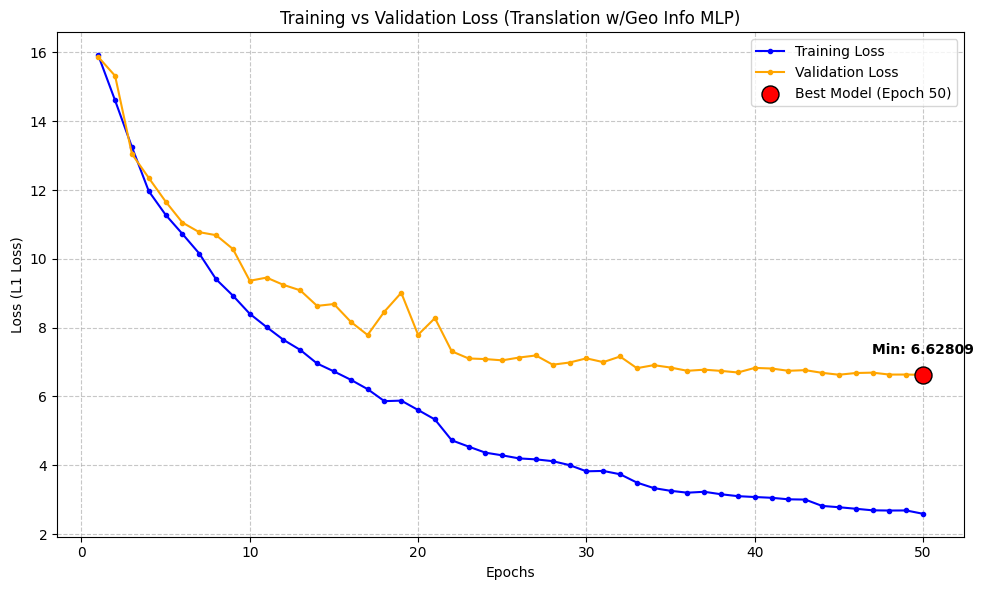

In [ ]:
import matplotlib.pyplot as plt
import os

# TRANSLATION MLP #5: Plotting

# -- PLOTTING --
print("\nGenerating Plots...")

plt.figure(figsize=(10, 6))
epochs_range = range(1, len(history['train']) + 1)

# Plot Lines
plt.plot(epochs_range, history['train'], label='Training Loss', marker='.', color='blue')
plt.plot(epochs_range, history['val'], label='Validation Loss', marker='.', color='orange')

# Find and Highlight the Best Epoch
if history['val']:
    best_val = min(history['val'])
    best_epoch = history['val'].index(best_val) + 1

    plt.scatter(best_epoch, best_val, color='red', s=150, zorder=5,
                label=f'Best Model (Epoch {best_epoch})', edgecolors='black')

    plt.annotate(f"Min: {best_val:.5f}", (best_epoch, best_val),
                 xytext=(0, 15), textcoords='offset points', ha='center', fontweight='bold')

plt.title('Training vs Validation Loss (Translation w/Geo Info MLP)')
plt.xlabel('Epochs')
plt.ylabel('Loss (L1 Loss)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

os.makedirs(drive_save_folder, exist_ok=True)

save_path = os.path.join(drive_save_folder, f"{EXP_ID}_loss_plot.png")
plt.savefig(save_path)
print(f"Plot saved to: {save_path}")

plt.show()

In [ ]:
# TRANSLATION MLP #6: Evaluation

# -- CAMERA INTRINSICS (LineMod) --
# Provided in your earlier context
FX = 572.4114
FY = 573.57043
CX = 325.2611
CY = 242.04899

# -- CONFIGURATION --
TEST_SPLIT_FILE = "test.txt"
BATCH_SIZE = 64

# Paths
best_model_path = os.path.join(drive_save_folder, f"best_{EXP_ID}.pth")
result_file_path = os.path.join(drive_save_folder, "final_translation_error.txt")

print(f"--- EVALUATION CONFIGURATION ---")
print(f"Weights: {best_model_path}")
print(f"YOLO:    {YOLO_PRED_DIR}")

# 1. Setup Test Dataset (With YOLO Logic)
test_ds = LineModDepthDataset(
    root_dir=DATASET_ROOT,
    split_file=TEST_SPLIT_FILE,
    input_size=112,
    yolo_root=YOLO_PRED_DIR
)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 2. Load Model
model = DepthZPredictor().to(DEVICE)

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    print(" -> Model weights loaded successfully.")
else:
    raise FileNotFoundError(f"Weights not found at: {best_model_path}")

model.eval()

# 3. Evaluation Loop
z_errors_abs = []
trans_errors_euclidean = []

print("Starting Inference...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        # Inputs
        depth = batch['depth'].to(DEVICE)     # [B, 1, 112, 112] (Meters)
        gt_t = batch['gt_t'].to(DEVICE)       # [B, 3] (Millimeters)
        bbox = batch['bbox'].to(DEVICE)       # [B, 4] (Pixels: x, y, w, h)

        # -----------------------------------------------
        # 1. REPLICATE TRAINING LOGIC for Z
        # -----------------------------------------------
        # Get Median in Meters (On-the-fly, same as training loop)
        z_base_m = depth.view(depth.size(0), -1).median(dim=1).values

        # Convert to MM (This is the 'coarse' guess)
        z_base_mm = z_base_m * 1000.0

        # Network predicts Delta (mm)
        pred_delta_mm = model(depth)

        # Final Z Prediction (mm)
        pred_z_mm = z_base_mm + pred_delta_mm

        # --------------------------------------------
        # 2. PINHOLE LOGIC for X and Y
        # --------------------------------------------
        # Center of bounding box
        x, y, w, h = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
        cx_bbox = x + (w / 2.0)
        cy_bbox = y + (h / 2.0)

        # X = (u - cx) * Z / fx
        # Y = (v - cy) * Z / fy
        pred_x_mm = (cx_bbox - CX) * pred_z_mm / FX
        pred_y_mm = (cy_bbox - CY) * pred_z_mm / FY

        # Stack into [B, 3] vector
        pred_t = torch.stack([pred_x_mm, pred_y_mm, pred_z_mm], dim=1)

        # -------------------------------------
        # 3. CALCULATE ERRORS
        # -------------------------------------
        # Z Error (Absolute difference)
        z_err = torch.abs(pred_z_mm - gt_t[:, 2])
        z_errors_abs.extend(z_err.cpu().numpy())

        # Euclidean Translation Error (Norm of difference vector)
        t_err = torch.norm(pred_t - gt_t, dim=1)
        trans_errors_euclidean.extend(t_err.cpu().numpy())

# 4. Final Statistics (Convert MM to CM)
mean_z_err_mm = np.mean(z_errors_abs)
mean_z_err_cm = mean_z_err_mm / 10.0

mean_trans_err_mm = np.mean(trans_errors_euclidean)
mean_trans_err_cm = mean_trans_err_mm / 10.0

print(f"\n=============================================")
print(f"FINAL RESULTS (Test Set - YOLO Boxes)")
print(f"=============================================")
print(f"Avg Z Error:           {mean_z_err_cm:.4f} cm")
print(f"Avg Translation Error: {mean_trans_err_cm:.4f} cm")
print(f"=============================================")

# 5. Save to Drive
with open(result_file_path, "w") as f:
    f.write(f"Experiment ID: {EXP_ID}\n")
    f.write(f"Weights: {best_model_path}\n")
    f.write(f"YOLO Source: {YOLO_PRED_DIR}\n")
    f.write(f"Evaluation Split: {TEST_SPLIT_FILE}\n")
    f.write(f"---------------------------------------------\n")
    f.write(f"Avg Z Error:           {mean_z_err_cm:.6f} cm\n")
    f.write(f"Avg Translation Error: {mean_trans_err_cm:.6f} cm\n")

print(f" -> Results saved to: {result_file_path}")

--- EVALUATION CONFIGURATION ---
Weights: /content/drive/MyDrive/6DAML/extension/T_CNN/T13_60-20-20_lr2e-04_dr02_b64_epc50_wd1e-04/best_T13_60-20-20.pth
YOLO:    /content/yolo/predictions_test_set_epc50
Parsing 3160 lines from test.txt...
 -> YOLO Mode Enabled. Source: /content/yolo/predictions_test_set_epc50
 -> Done! Loaded 3160 samples.
 -> Model weights loaded successfully.
Starting Inference...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


FINAL RESULTS (Test Set - YOLO Boxes)
Avg Z Error:           0.6736 cm
Avg Translation Error: 1.2739 cm
 -> Results saved to: /content/drive/MyDrive/6DAML/extension/T_CNN/T13_60-20-20_lr2e-04_dr02_b64_epc50_wd1e-04/final_translation_error.txt


In [ ]:
# ROTATION ESTIMATION #1: Dataset Class

class LineModFusionDataset(Dataset):
    def __init__(self, root_dir, split_file, input_size=224, yolo_root=None):
        """
        Loads RGB + Depth + Rotation Matrix for the Fusion Model.
        Args:
            root_dir: Path to dataset root (e.g., 'datasets/linemod/data')
            split_file: Path to train.txt, val.txt, or test.txt
            input_size: Target size for CNN (default 224 for ResNet)
            yolo_root: Optional path to YOLO predictions (for Test set)
        """
        self.root_dir = root_dir
        self.input_size = input_size
        self.yolo_root = yolo_root
        self.samples = []

        # Image Dimensions for YOLO conversion
        self.IMG_W = 640
        self.IMG_H = 480

        # Standard ImageNet normalization for RGB
        self.rgb_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.input_size, self.input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # 1. Parse Split File
        if not os.path.exists(split_file):
            # Try absolute path fallback
            if os.path.exists(os.path.join(root_dir, split_file)):
                split_file = os.path.join(root_dir, split_file)
            else:
                raise FileNotFoundError(f"Split file not found: {split_file}")

        print(f"Parsing {os.path.basename(split_file)}...")
        if self.yolo_root:
            print(f" -> YOLO Mode Enabled. Source: {self.yolo_root}")

        with open(split_file, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]

        # Cache to avoid re-reading gt.yml thousands of times
        gt_cache = {}

        for line in lines:
            parts = line.split('/')
            try:
                # Robust ID extraction
                if 'data' in parts:
                    data_idx = parts.index('data')
                    obj_id_str = parts[data_idx + 1]
                else:
                    obj_id_str = parts[-3] # Fallback

                img_id = int(os.path.splitext(parts[-1])[0])
            except (ValueError, IndexError):
                continue

            # Load GT (Cached)
            if obj_id_str not in gt_cache:
                gt_path = os.path.join(root_dir, obj_id_str, "gt.yml")
                if os.path.exists(gt_path):
                    with open(gt_path, 'r') as f:
                        gt_cache[obj_id_str] = yaml.safe_load(f)
                else:
                    gt_cache[obj_id_str] = None

            gt_data = gt_cache[obj_id_str]
            if gt_data is None or img_id not in gt_data: continue

            # Find Annotation
            target_obj_id = int(obj_id_str)
            target_ann = None
            for ann in gt_data[img_id]:
                if ann['obj_id'] == target_obj_id:
                    target_ann = ann
                    break

            if target_ann is None: continue

            # Construct Paths
            base = os.path.join(root_dir, obj_id_str)
            rgb_path = os.path.join(base, "rgb", f"{img_id:04d}.png")
            depth_path = os.path.join(base, "depth", f"{img_id:04d}.png")

            if not os.path.exists(rgb_path) or not os.path.exists(depth_path): continue

            self.samples.append({
                'rgb_path': rgb_path,
                'depth_path': depth_path,
                'bbox': target_ann['obj_bb'],      # GT [x, y, w, h]
                'cam_R_m2c': target_ann['cam_R_m2c'],
                'obj_id': target_obj_id,
                'obj_id_str': obj_id_str,          # Needed for YOLO path
                'img_id': img_id                   # Needed for YOLO path
            })

        print(f"-> Loaded {len(self.samples)} samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # 1. Load Images
        rgb = cv2.imread(sample['rgb_path'])
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) # BGR -> RGB

        depth = cv2.imread(sample['depth_path'], -1) # 16-bit
        if depth is None: depth = np.zeros((480, 640), dtype=np.uint16)

        # 2. Determine Bounding Box (YOLO vs GT)
        # Start with GT
        x, y, w, h = map(int, sample['bbox'])

        # Check for YOLO
        if self.yolo_root:
            # Path: yolo_root/01/0000.txt
            yolo_file = os.path.join(self.yolo_root, sample['obj_id_str'], f"{sample['img_id']:04d}.txt")

            if os.path.exists(yolo_file):
                try:
                    with open(yolo_file, 'r') as f:
                        content = f.read().strip().split()
                        # Format: class cx_n cy_n w_n h_n
                        if len(content) >= 5:
                            cx_n, cy_n, w_n, h_n = map(float, content[1:5])

                            # Convert normalized -> pixels
                            w_pix = w_n * self.IMG_W
                            h_pix = h_n * self.IMG_H
                            cx_pix = cx_n * self.IMG_W
                            cy_pix = cy_n * self.IMG_H

                            x = int(cx_pix - (w_pix / 2))
                            y = int(cy_pix - (h_pix / 2))
                            w = int(w_pix)
                            h = int(h_pix)
                except Exception:
                    pass # Keep GT if YOLO fails

        # 3. Crop
        # Clamp Logic
        H, W = depth.shape
        x = max(0, x); y = max(0, y)
        w = min(w, W - x); h = min(h, H - y)

        if w <= 5 or h <= 5: # Fallback for bad/missing boxes
            # Resize full image if crop is invalid
            rgb_crop = cv2.resize(rgb, (self.input_size, self.input_size))
            depth_crop = cv2.resize(depth, (self.input_size, self.input_size))
        else:
            rgb_crop = rgb[y:y+h, x:x+w]
            depth_crop = depth[y:y+h, x:x+w]

        # 4. Process RGB (Resize -> Tensor -> Normalize)
        rgb_tensor = self.rgb_transform(rgb_crop)

        # 5. Process Depth (Resize -> Meter Scale -> Tensor)
        depth_crop = cv2.resize(depth_crop, (self.input_size, self.input_size), interpolation=cv2.INTER_NEAREST)
        depth_tensor = torch.tensor(depth_crop.astype(np.float32) / 1000.0).unsqueeze(0) # [1, 224, 224]

        # 6. Process Rotation (Flattened -> 3x3 Matrix)
        rot_flat = np.array(sample['cam_R_m2c'], dtype=np.float32)
        rot_matrix = torch.from_numpy(rot_flat).view(3, 3)

        return {
            'rgb': rgb_tensor,
            'depth': depth_tensor,
            'cam_R_m2c': rot_matrix,
            'obj_id': sample['obj_id']
        }

In [ ]:
# ROTATION ESTIMATION #2: Data Loader Calls

# Configuration
ROOT_DIR = '/content/datasets/linemod/Linemod_preprocessed/data'
YOLO_PRED_DIR = "/content/yolo/predictions_test_set_epc50"
BATCH_SIZE = 32

print(f"Dataset Root: {ROOT_DIR}")
print(f"YOLO Root (Test Only): {YOLO_PRED_DIR}")

# 1. Instantiate Datasets
# Train/Val: yolo_root=None (Use Ground Truth)
ext_train_dataset = LineModFusionDataset(ROOT_DIR, split_file='train.txt', input_size=224, yolo_root=None)
ext_val_dataset   = LineModFusionDataset(ROOT_DIR, split_file='val.txt',   input_size=224, yolo_root=None)

# Test: yolo_root=YOLO_PRED_DIR (Use Predicted Boxes)
ext_test_dataset  = LineModFusionDataset(ROOT_DIR, split_file='test.txt',  input_size=224, yolo_root=YOLO_PRED_DIR)

# 2. Create Loaders
fusion_train_loader = DataLoader(ext_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
fusion_val_loader   = DataLoader(ext_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
fusion_test_loader  = DataLoader(ext_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Loaders Ready:")
print(f"  Train: {len(ext_train_dataset)} samples")
print(f"  Val:   {len(ext_val_dataset)} samples")
print(f"  Test:  {len(ext_test_dataset)} samples (Using YOLO)")

Dataset Root: /content/datasets/linemod/Linemod_preprocessed/data
YOLO Root (Test Only): /content/yolo/predictions_test_set_epc50
Parsing train.txt...
-> Loaded 9480 samples.
Parsing val.txt...
-> Loaded 3160 samples.
Parsing test.txt...
 -> YOLO Mode Enabled. Source: /content/yolo/predictions_test_set_epc50
-> Loaded 3160 samples.
Loaders Ready:
  Train: 9480 samples
  Val:   3160 samples
  Test:  3160 samples (Using YOLO)


In [ ]:
# ROTATION ESTIMATION #3: 6D to 3x3 RotMatrix Function

def compute_rotation_matrix_from_ortho6d(ortho6d):
    """
    Converts 6D continuous representation to 3x3 Rotation Matrix.
    Based on Zhou et al., CVPR 2019.
    Input: [Batch_Size, 6] (Two 3D vectors: a1, a2)
    Output: [Batch_Size, 3, 3] (Rotation Matrix)
    """
    # Split the 6D vector into two 3D vectors
    x_raw = ortho6d[:, 0:3] # Vector 1
    y_raw = ortho6d[:, 3:6] # Vector 2

    # 1. Normalize the first vector
    x = F.normalize(x_raw, dim=1)

    # 2. Compute the third vector using cross product (ensure orthogonality)
    z = torch.cross(x, y_raw, dim=1)
    z = F.normalize(z, dim=1)

    # 3. Compute the second vector to complete the basis
    y = torch.cross(z, x, dim=1)

    # 4. Stack into a matrix
    x = x.view(-1, 3, 1)
    y = y.view(-1, 3, 1)
    z = z.view(-1, 3, 1)

    # Final 3x3 Rotation Matrix
    matrix = torch.cat((x, y, z), 2)
    return matrix

In [ ]:
# ROTATION ESTIMATION #4: Depth Predictor for Rotation

DROPOUT_ROT = 0.1

class DepthZPredictorRot(nn.Module):
    def __init__(self):
        super(DepthZPredictorRot, self).__init__()

        # Input: 1 Channel (Depth)
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # 224 -> 112

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # 112 -> 56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # 56 -> 28

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2), # 28 -> 14 (Final Size)
        )

        self.flatten = nn.Flatten()

        # 512 channels * 14 * 14 spatial = 100,352 features
        self.fc1 = nn.Linear(512 * 14 * 14, 512)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(DROPOUT_ROT)

        # This is the "Feature Vector" we want to share (128 dims)
        self.fc2 = nn.Linear(512, 128)

        # This is the final head for Z prediction
        self.head_z = nn.Linear(128, 1)

    def forward(self, x, return_features=False):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Get the rich geometric features (128 dim)
        feat = self.fc2(x)
        feat = self.relu(feat)

        if return_features:
            return feat # Return 128-dim vector for fusion

        # Standard behavior: Predict Z
        out = self.head_z(feat)
        return out.squeeze(1)

In [ ]:
# ROTATION ESTIMATION #5.1: ResNet-50 Model
# Rotation ResNet-50

from torchvision import models
class RGBDFusionRotation(nn.Module):
    def __init__(self, depth_model_path=None):
        super(RGBDFusionRotation, self).__init__()

        # --- 1. RGB Branch (ResNet50) ---
        resnet = models.resnet50(weights='DEFAULT')
        # ResNet50 output before FC is 2048 dimensions
        self.rgb_backbone = nn.Sequential(*list(resnet.children())[:-1])

        # --- 2. Depth Branch (Your DepthZPredictor) ---
        self.depth_backbone = DepthZPredictorRot()

        # Optional: Load pre-trained weights for the depth branch if you have them
        if depth_model_path:
            self.depth_backbone.load_state_dict(torch.load(depth_model_path))
            print("Loaded pre-trained Depth weights.")
            # Optional: Freeze depth weights to prevent degrading Z prediction
            # for param in self.depth_backbone.parameters():
            #     param.requires_grad = False

        # --- 3. Fusion Block ---
        # RGB (2048) + Depth (128) = 2176 inputs
        self.fusion_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048 + 128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 256),
            nn.ReLU()
        )

        # --- 4. Rotation Head (6D Representation) ---
        # Outputs 6 values (a1, a2) instead of 4 (quaternions)
        self.head_6d = nn.Linear(256, 6)

    def forward(self, rgb, depth):
        # 1. Process RGB
        rgb_feat = self.rgb_backbone(rgb) # [Batch, 2048, 1, 1]
        rgb_feat = rgb_feat.view(rgb_feat.size(0), -1) # Flatten -> [Batch, 2048]

        # 2. Process Depth (Extract features, don't predict Z)
        depth_feat = self.depth_backbone(depth, return_features=True) # [Batch, 128]

        # 3. Late Fusion
        combined = torch.cat((rgb_feat, depth_feat), dim=1) # [Batch, 2176]

        # 4. Predict 6D Vector
        fused = self.fusion_fc(combined)
        ortho6d = self.head_6d(fused) # [Batch, 6]

        # 5. Convert to Rotation Matrix
        rot_matrix = compute_rotation_matrix_from_ortho6d(ortho6d) # [Batch, 3, 3]

        return rot_matrix

In [ ]:
# ROTATION ESTIMATION #5.2: EfficientNet Model
# Rotation EfficientNet

from torchvision.models import efficientnet_b3

class RGBDFusionRotation(nn.Module):
    def __init__(self, depth_model_path=None):
        super(RGBDFusionRotation, self).__init__()

        # --- 1. RGB Branch (EfficientNet-B3) ---
        # EfficientNet separates 'features' (Conv layers) and 'classifier' (FC layers)
        effnet = models.efficientnet_b3(weights='DEFAULT')

        # We take the features + the global average pooling layer
        # Output shape will be [Batch, 1536, 1, 1]
        self.rgb_backbone = nn.Sequential(
            effnet.features,
            effnet.avgpool
        )

        # --- 2. Depth Branch (DepthZPredictorRot) ---
        self.depth_backbone = DepthZPredictorRot()

        # Optional: Load pre-trained weights for the depth branch if you have them
        if depth_model_path:
            self.depth_backbone.load_state_dict(torch.load(depth_model_path))
            print("Loaded pre-trained Depth weights.")
            # Optional: Freeze depth weights to prevent degrading Z prediction
            # for param in self.depth_backbone.parameters():
            #     param.requires_grad = False

        # --- 3. Fusion Block ---
        # RGB (2048) + Depth (128) = 2176 inputs
        self.fusion_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1536 + 128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 256),
            nn.ReLU()
        )

        # --- 4. Rotation Head (6D Representation) ---
        # Outputs 6 values (a1, a2) instead of 4 (quaternions)
        self.head_6d = nn.Linear(256, 6)

    def forward(self, rgb, depth):
        # 1. Process RGB
        rgb_feat = self.rgb_backbone(rgb) # [Batch, 2048, 1, 1]
        rgb_feat = rgb_feat.view(rgb_feat.size(0), -1) # Flatten -> [Batch, 2048]

        # 2. Process Depth (Extract features, don't predict Z)
        depth_feat = self.depth_backbone(depth, return_features=True) # [Batch, 128]

        # 3. Late Fusion
        combined = torch.cat((rgb_feat, depth_feat), dim=1) # [Batch, 2176]

        # 4. Predict 6D Vector
        fused = self.fusion_fc(combined)
        ortho6d = self.head_6d(fused) # [Batch, 6]

        # 5. Convert to Rotation Matrix
        rot_matrix = compute_rotation_matrix_from_ortho6d(ortho6d) # [Batch, 3, 3]

        return rot_matrix

In [ ]:
# ROTATION ESTIMATION #6: Geodesic Rotation Loss Function

class GeodesicRotationLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super(GeodesicRotationLoss, self).__init__()
        self.eps = eps

    def forward(self, pred_R, gt_R):
        # pred_R: [Batch, 3, 3]
        # gt_R:   [Batch, 3, 3] (Ground Truth)

        # Compute R_diff = R_pred * R_gt.T
        # For valid rotation matrices, Trace(R_diff) = 1 + 2cos(theta)
        m = torch.bmm(pred_R, gt_R.transpose(1, 2)) # Batch Matrix Multiplication

        # Trace of 3x3 matrix is sum of diagonal elements
        trace = m[:, 0, 0] + m[:, 1, 1] + m[:, 2, 2]

        # Clamp to ensure stability (arccos requires value between -1 and 1)
        trace_clamped = torch.clamp((trace - 1) / 2, -1 + self.eps, 1 - self.eps)

        # Calculate angle (theta)
        theta = torch.acos(trace_clamped)

        # Return mean angle error (radians)
        return theta.mean()

In [ ]:
# ROTATION ESTIMATION #7: Model Initializiation

# 1. Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 50
DROPOUT_ROT = 0.1

# 2. Instantiate the Fusion Model
# If there is a saved model for Z-Predictor (Translation), put the path here.
# Otherwise, leave it None to initialize random weights for the depth branch.
z_predictor_path = None # e.g., "checkpoints/z_predictor_best.pth"

model = RGBDFusionRotation(depth_model_path=z_predictor_path)
model = model.to(DEVICE)

# 3. Define Loss and Optimizer
criterion = GeodesicRotationLoss()

# We optimize ALL parameters (RGB backbone + Depth backbone + Fusion head)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler to lower LR when loss plateaus (Best Practice)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"Model initialized on {DEVICE}")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 237MB/s]


Model initialized on cuda


In [ ]:
# ROTATION ESTIMATION #8: Train One Epoch Function

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(loader):
        # --- 1. Data Preparation ---
        # Move data to GPU
        rgb = batch['rgb'].to(device)       # [B, 3, H, W]
        depth = batch['depth'].to(device)   # [B, 1, H, W]

        # Ground Truth Rotation Matrix
        if 'cam_R_m2c' in batch:
            gt_rot = batch['cam_R_m2c'].to(device)
        elif 'rotation' in batch:
             gt_rot = batch['rotation'].to(device)
        else:
            raise KeyError("Could not find rotation matrix in batch. Check Dataloader keys.")

        if gt_rot.dim() == 2:
            gt_rot = gt_rot.view(-1, 3, 3) # Reshape 9 -> 3x3 if needed

        # --- 2. Forward Pass ---
        optimizer.zero_grad()

        # Predict Rotation Matrix
        pred_rot_matrix = model(rgb, depth)

        # --- 3. Loss Calculation ---
        # Geodesic Loss calculates the angular difference
        loss = criterion(pred_rot_matrix, gt_rot)

        # --- 4. Backward Pass ---
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_angular_error_deg = 0.0

    with torch.no_grad():
        for batch in loader:
            rgb = batch['rgb'].to(device)
            depth = batch['depth'].to(device)

            if 'cam_R_m2c' in batch:
                gt_rot = batch['cam_R_m2c'].to(device)
            else:
                 print("Cannot find cam_R_m2c field in gt.yml.")
                 gt_rot = batch['rotation'].to(device)

            if gt_rot.dim() == 2:
                gt_rot = gt_rot.view(-1, 3, 3)

            pred_rot_matrix = model(rgb, depth)
            loss = criterion(pred_rot_matrix, gt_rot)

            running_loss += loss.item()

            total_angular_error_deg += torch.rad2deg(loss).item()

    avg_loss = running_loss / len(loader)
    avg_angle_error = total_angular_error_deg / len(loader)
    return avg_loss, avg_angle_error

In [ ]:
# ROTATION ESTIMATION #9: Main Training Loop

# --- PATH CONSTRUCTION ---
BASE_SAVE_DIR = '/content/drive/MyDrive/6DAML/extension'
EXP_ID = "R04_60-20-20_effnet"
model_folder_name = f"{EXP_ID}_lr{LEARNING_RATE:.0e}_dr{str(DROPOUT_ROT).replace('.','')}_b{BATCH_SIZE}_epc{NUM_EPOCHS}_wd{WEIGHT_DECAY:.0e}"

# Drive Path
drive_save_folder = os.path.join(BASE_SAVE_DIR, "R_Fusion", model_folder_name)
os.makedirs(drive_save_folder, exist_ok=True)

# Runtime Path (Local)
local_save_folder = os.path.join("/content", model_folder_name)
os.makedirs(local_save_folder, exist_ok=True)

def format_time(seconds):
    """Converts seconds to h:mm:ss string"""
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return f"{h}h {m:02d}m {s:02d}s"

print(f"Starting Training on {DEVICE}...")
print(f"Saving to: {drive_save_folder}")
print("-" * 60)

best_val_error = float('inf')
total_start_time = time.time()

# --- Initialize History Container & File ---
history = {'train_loss': [], 'val_loss': [], 'val_angle_error': []}
history_file = os.path.join(drive_save_folder, "history.csv")

# Create CSV with Header
with open(history_file, "w") as f:
    f.write("Epoch,Train_Loss,Val_Loss,Val_Angle_Error,LR\n")

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- 1. TRAIN ---
    train_loss = train_one_epoch(model, fusion_train_loader, optimizer, criterion, DEVICE)

    # --- 2. VALIDATE ---
    val_loss, val_angle_error = validate(model, fusion_val_loader, criterion, DEVICE)

    # --- 3. SCHEDULER ---
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # --- 4. HISTORY UPDATES ---
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_angle_error'].append(val_angle_error)

    # Append to CSV
    with open(history_file, "a") as f:
        f.write(f"{epoch+1},{train_loss:.6f},{val_loss:.6f},{val_angle_error:.6f},{current_lr:.6e}\n")

    # --- 5. TIMING ---
    epoch_duration = time.time() - epoch_start_time
    epochs_left = NUM_EPOCHS - (epoch + 1)
    eta_seconds = epochs_left * epoch_duration

    # --- 6. SAVE BEST MODEL ---
    if val_angle_error < best_val_error:
        best_val_error = val_angle_error

        # Filename: best_R03_60-20-20.pth
        best_model_name = f"best_{EXP_ID}.pth"

        # Save to Local
        local_path = os.path.join(local_save_folder, best_model_name)
        torch.save(model.state_dict(), local_path)

        # Save to Drive
        drive_path = os.path.join(drive_save_folder, best_model_name)
        torch.save(model.state_dict(), drive_path)

        save_msg = "-> Saved Best!"
    else:
        save_msg = ""

    # --- 7. LOGGING ---
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"   Time: {format_time(epoch_duration)} (ETA: {format_time(eta_seconds)})")
    print(f"   LR: {current_lr:.6f}")
    print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"   Avg Val Error: {val_angle_error:.2f}° {save_msg}")
    print("-" * 60)

total_duration = time.time() - total_start_time
print(f"Training Complete. Total time: {format_time(total_duration)}")
print(f"History saved to: {history_file}")

Starting Training on cuda...
Saving to: /content/drive/MyDrive/6DAML/extension/R_Fusion/R04_60-20-20_effnet_lr1e-04_dr01_b64_epc50_wd1e-05
------------------------------------------------------------
Epoch [1/50]
   Time: 0h 02m 54s (ETA: 2h 22m 27s)
   LR: 0.000100
   Train Loss: 1.3823 | Val Loss: 0.8499
   Avg Val Error: 48.70° -> Saved Best!
------------------------------------------------------------
Epoch [2/50]
   Time: 0h 02m 55s (ETA: 2h 20m 26s)
   LR: 0.000100
   Train Loss: 0.6874 | Val Loss: 0.4317
   Avg Val Error: 24.74° -> Saved Best!
------------------------------------------------------------
Epoch [3/50]
   Time: 0h 02m 55s (ETA: 2h 17m 49s)
   LR: 0.000100
   Train Loss: 0.4117 | Val Loss: 0.2931
   Avg Val Error: 16.80° -> Saved Best!
------------------------------------------------------------
Epoch [4/50]
   Time: 0h 02m 55s (ETA: 2h 14m 19s)
   LR: 0.000100
   Train Loss: 0.3250 | Val Loss: 0.2459
   Avg Val Error: 14.09° -> Saved Best!
-------------------------


Generating Plots...
Loss plot saved to: /content/drive/MyDrive/6DAML/extension/R_Fusion/R04_60-20-20_effnet_lr1e-04_dr01_b64_epc50_wd1e-05/loss_plot.png


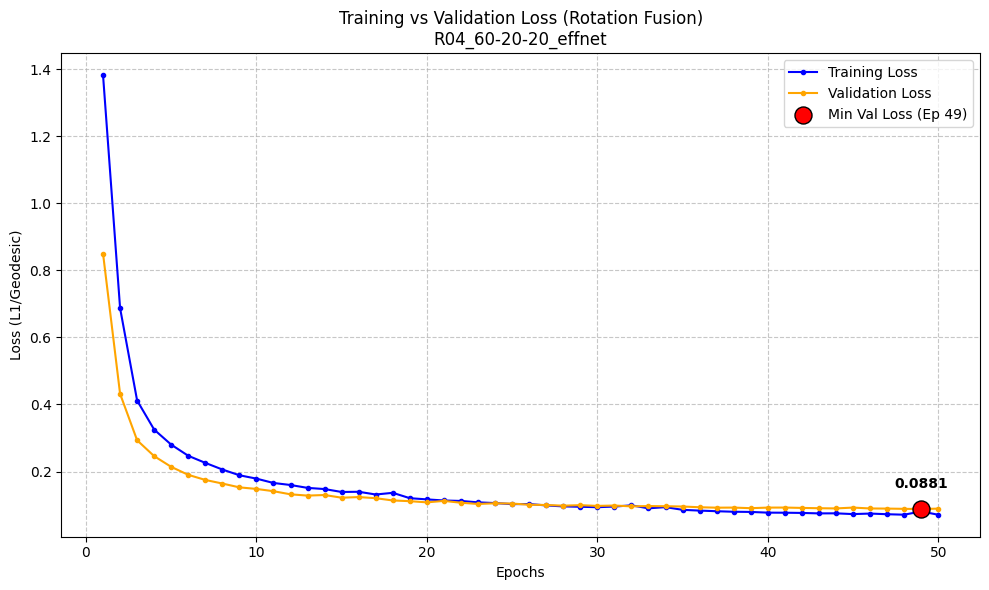

Error plot saved to: /content/drive/MyDrive/6DAML/extension/R_Fusion/R04_60-20-20_effnet_lr1e-04_dr01_b64_epc50_wd1e-05/angle_error_plot.png


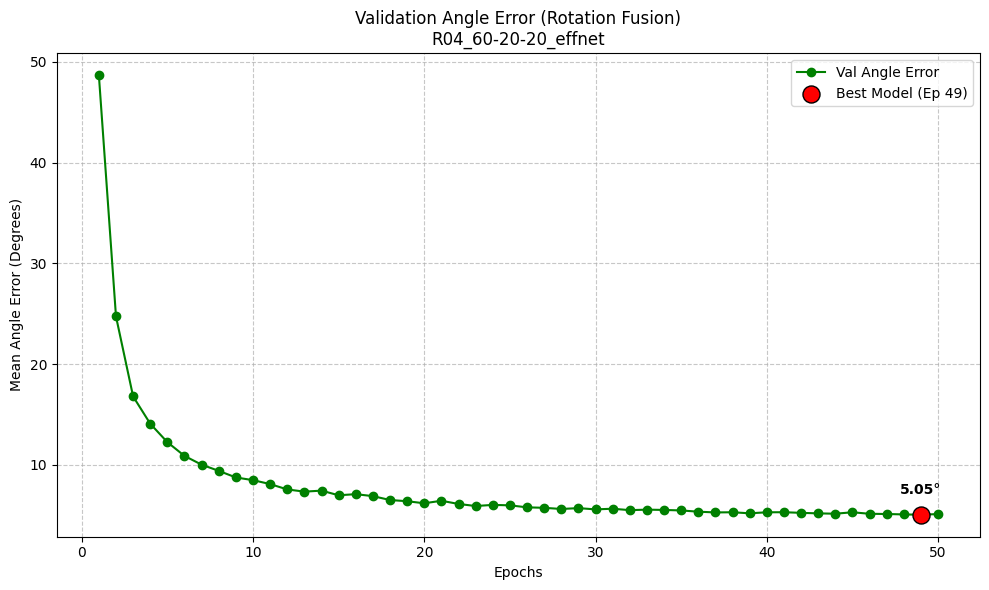

In [ ]:
# ROTATION ESTIMATION #10: Plotting

print("\nGenerating Plots...")

# Ensure output directory exists
os.makedirs(drive_save_folder, exist_ok=True)

# --- PLOT 1: LOSS (Train vs Val) ---
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(history['train_loss']) + 1)

# Plot Lines
plt.plot(epochs_range, history['train_loss'], label='Training Loss', marker='.', color='blue')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='.', color='orange')

# Find and Highlight the Best Epoch
if history['val_loss']:
    min_loss = min(history['val_loss'])
    best_loss_idx = history['val_loss'].index(min_loss) + 1

    plt.scatter(best_loss_idx, min_loss, color='red', s=150, zorder=5,
                label=f'Min Val Loss (Ep {best_loss_idx})', edgecolors='black')

    plt.annotate(f"{min_loss:.4f}", (best_loss_idx, min_loss),
                 xytext=(0, 15), textcoords='offset points', ha='center', fontweight='bold')

plt.title(f'Training vs Validation Loss (Rotation Fusion)\n{EXP_ID}')
plt.xlabel('Epochs')
plt.ylabel('Loss (L1/Geodesic)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save Plot 1
plot_path_loss = os.path.join(drive_save_folder, "loss_plot.png")
plt.savefig(plot_path_loss)
print(f"Loss plot saved to: {plot_path_loss}")
plt.show()

# --- PLOT 2: ANGLE ERROR (Val Only) ---
plt.figure(figsize=(10, 6))

# Plot Line
plt.plot(epochs_range, history['val_angle_error'], label='Val Angle Error', marker='o', color='green')

# Find Best Angle Error
if history['val_angle_error']:
    min_err = min(history['val_angle_error'])
    best_err_idx = history['val_angle_error'].index(min_err) + 1

    plt.scatter(best_err_idx, min_err, color='red', s=150, zorder=5,
                label=f'Best Model (Ep {best_err_idx})', edgecolors='black')

    plt.annotate(f"{min_err:.2f}°", (best_err_idx, min_err),
                 xytext=(0, 15), textcoords='offset points', ha='center', fontweight='bold')

plt.title(f'Validation Angle Error (Rotation Fusion)\n{EXP_ID}')
plt.xlabel('Epochs')
plt.ylabel('Mean Angle Error (Degrees)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save Plot 2
plot_path_err = os.path.join(drive_save_folder, "angle_error_plot.png")
plt.savefig(plot_path_err)
print(f"Error plot saved to: {plot_path_err}")
plt.show()

In [ ]:
# ADD METRIC TABLE GENERATION #

# --- 1. CONFIGURATION ---
BASE_SAVE_DIR = "/content/drive/MyDrive/6DAML/extension"
RESULT_SAVE_PATH = os.path.join(BASE_SAVE_DIR, "evaluation_results_T09_R03.txt")

# Data Paths
DATA_ROOT = "/content/datasets/linemod/Linemod_preprocessed/data"
MESH_PATH_TEMPLATE = "/content/datasets/linemod/Linemod_preprocessed/models/obj_{:02d}.ply"
TEST_SPLIT_FILE = os.path.join(DATA_ROOT, "test.txt")
MODELS_INFO_PATH = "/content/datasets/linemod/Linemod_preprocessed/models/models_info.yml"
YOLO_PREDS_PATH = "/content/yolo/predictions_test_set_epc50"

# Model Paths
PATH_T_CNN = os.path.join(BASE_SAVE_DIR, "T_CNN", "T09_60-20-20_lr2e-04_dr03_b64_epc50_wd1e-04", "best_T09_60-20-20.pth")
PATH_R_FUSION = os.path.join(BASE_SAVE_DIR, "R_Fusion", "R03_60-20-20_resnet_lr1e-04_dr01_b32_epc50_wd1e-05", "best_R03_60-20-20_resnet.pth")

# Constants
SYMMETRIC_IDS = [10, 11] # Eggbox, Glue
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# --- 2. EVALUATOR CLASS ---
class SixDPoseEvaluator:
    def __init__(self, mesh_template, symmetric_ids, diameters_path):
        self.mesh_template = mesh_template
        self.symmetric_ids = symmetric_ids
        self.meshes = {}
        self.diameters = self._load_diameters(diameters_path)

    def _load_diameters(self, path):
        if not os.path.exists(path):
            # Fallback diameters (Meters)
            return {1: 0.102, 2: 0.247, 3: 0.127, 4: 0.117, 5: 0.150,
                    6: 0.127, 8: 0.152, 9: 0.151, 10: 0.151, 11: 0.165,
                    12: 0.169, 13: 0.207, 14: 0.239, 15: 0.163}
        with open(path, 'r') as f:
            data = yaml.safe_load(f)
        return {int(k): v['diameter'] / 1000.0 for k, v in data.items()}

    def load_mesh(self, obj_id):
        if obj_id not in self.meshes:
            path = self.mesh_template.format(obj_id)
            if os.path.exists(path):
                mesh = trimesh.load(path)
                # Keep full resolution for accuracy, or downsample if >5k vertices for speed
                self.meshes[obj_id] = mesh.vertices * 0.001 # MM to Meters
            else:
                self.meshes[obj_id] = np.random.rand(500, 3) * 0.1 # Dummy fallback
        return self.meshes[obj_id]

    def compute_add(self, gt_R, gt_t, pred_R, pred_t, vertices):
        """Standard ADD: Average distance between transformed model points."""
        gt_pts = (np.dot(vertices, gt_R.T) + gt_t)
        pred_pts = (np.dot(vertices, pred_R.T) + pred_t)
        return np.mean(np.linalg.norm(gt_pts - pred_pts, axis=1))

    def compute_add_s(self, gt_R, gt_t, pred_R, pred_t, vertices):
        """ADD-S: Average distance to nearest neighbor (for symmetric objects)."""
        gt_pts = (np.dot(vertices, gt_R.T) + gt_t)
        pred_pts = (np.dot(vertices, pred_R.T) + pred_t)

        # Use KDTree for efficiency with larger meshes
        from scipy.spatial import cKDTree
        tree = cKDTree(pred_pts)
        dist, _ = tree.query(gt_pts)
        return np.mean(dist)

    def evaluate_sample(self, obj_id, pred_R, pred_t, gt_R, gt_t):
        verts = self.load_mesh(obj_id)
        diameter = self.diameters.get(obj_id, 0.1)

        # 1. ADD (Always compute standard ADD)
        add_val = self.compute_add(gt_R, gt_t, pred_R, pred_t, verts)

        # 2. ADD-S (Compute for symmetric, None for others)
        if obj_id in self.symmetric_ids:
            adds_val = self.compute_add_s(gt_R, gt_t, pred_R, pred_t, verts)
        else:
            adds_val = None # Not applicable

        # 3. ADD-R (Rotation Only)
        zero_t = np.zeros(3)
        if obj_id in self.symmetric_ids:
            addr_val = self.compute_add_s(gt_R, zero_t, pred_R, zero_t, verts)
        else:
            addr_val = self.compute_add(gt_R, zero_t, pred_R, zero_t, verts)

        # 4. Pose Errors
        trans_error = np.linalg.norm(gt_t - pred_t)

        # Geodesic Rotation Error
        R_diff = np.dot(pred_R, gt_R.T)
        trace = np.trace(R_diff)
        trace = np.clip((trace - 1) / 2, -1.0, 1.0)
        rot_error_deg = np.rad2deg(np.arccos(trace))

        return {
            "obj_id": obj_id,
            "add": add_val,
            "adds": adds_val, # Can be None
            "addr": addr_val,
            "trans_error": trans_error,
            "rot_error": rot_error_deg,
            "diameter": diameter
        }

In [ ]:
# --- 3. DATA LOADING & INFERENCE HELPERS ---
def preload_yolo(root_path):
    """Caches YOLO results: cache[obj_str][img_id] = (x,y,w,h) normalized"""
    print(f"Caching YOLO predictions from {root_path}...")
    cache = {}
    obj_folders = [f for f in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, f))]
    for obj in tqdm(obj_folders, desc="Loading YOLO"):
        files = glob.glob(os.path.join(root_path, obj, "*.txt"))
        if obj not in cache: cache[obj] = {}
        for fpath in files:
            try:
                iid = int(os.path.basename(fpath).split('.')[0])
                with open(fpath, 'r') as f:
                    d = list(map(float, f.read().strip().split()))
                cache[obj][iid] = d[1:5]
            except: continue
    return cache

def get_bbox(cache, obj_str, img_id, W, H):
    if obj_str not in cache or img_id not in cache[obj_str]: return None
    xc, yc, w, h = cache[obj_str][img_id]
    x = int((xc - w/2) * W)
    y = int((yc - h/2) * H)
    return (x, y, int(w*W), int(h*H))

# --- 4. MAIN EXECUTION ---

def run_evaluation():
    # 1. Setup Models
    print("Loading Models...")

    t_model = DepthZPredictor().to(DEVICE)
    t_model.load_state_dict(torch.load(PATH_T_CNN, map_location=DEVICE))
    t_model.eval()

    r_model = RGBDFusionRotation().to(DEVICE)
    r_model.load_state_dict(torch.load(PATH_R_FUSION, map_location=DEVICE))
    r_model.eval()

    # 2. Setup Evaluator
    evaluator = SixDPoseEvaluator(MESH_PATH_TEMPLATE, SYMMETRIC_IDS, MODELS_INFO_PATH)
    yolo_cache = preload_yolo(YOLO_PREDS_PATH)

    # 3. Load Test Split
    with open(TEST_SPLIT_FILE, 'r') as f:
        test_lines = [x.strip() for x in f.readlines() if x.strip()]

    # Transform
    rgb_tf = transforms.Compose([
        transforms.ToPILImage(), transforms.Resize((224, 224)),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    results = []
    gt_cache_mem = {}

    print(f"Evaluating {len(test_lines)} samples...")
    for line in tqdm(test_lines):
        # Parse path: data/01/rgb/0000.png
        parts = line.split('/')
        try:
            if 'data' in parts:
                obj_id_str = parts[parts.index('data')+1]
            else:
                obj_id_str = parts[-3] # Fallback
            img_id = int(parts[-1].split('.')[0])
            obj_id = int(obj_id_str)
        except: continue

        # Load Metadata
        if obj_id_str not in gt_cache_mem:
            gp = os.path.join(DATA_ROOT, obj_id_str, "gt.yml")
            ip = os.path.join(DATA_ROOT, obj_id_str, "info.yml")
            if os.path.exists(gp) and os.path.exists(ip):
                with open(gp) as f: gt_cache_mem[obj_id_str] = yaml.safe_load(f)
                with open(ip) as f: gt_cache_mem[obj_id_str+"_i"] = yaml.safe_load(f)
            else: gt_cache_mem[obj_id_str] = None

        gts = gt_cache_mem[obj_id_str]
        infos = gt_cache_mem.get(obj_id_str+"_i")

        if not gts or img_id not in gts: continue

        ann = next((a for a in gts[img_id] if a['obj_id'] == obj_id), None)
        if ann is None: continue

        # Load Data
        rgb_p = os.path.join(DATA_ROOT, obj_id_str, "rgb", f"{img_id:04d}.png")
        depth_p = os.path.join(DATA_ROOT, obj_id_str, "depth", f"{img_id:04d}.png")

        rgb = cv2.imread(rgb_p)
        depth = cv2.imread(depth_p, -1) # Uint16 mm
        if rgb is None or depth is None: continue

        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        H, W_img = depth.shape

        # Get BBox
        bbox = get_bbox(yolo_cache, obj_id_str, img_id, W_img, H)
        if not bbox: continue
        x, y, w, h = bbox

        # Clamping
        x, y = max(0, x), max(0, y)
        w, h = min(w, W_img - x), min(h, H - y)
        if w < 5 or h < 5: continue

        # Crop
        rgb_crop = rgb[y:y+h, x:x+w]
        depth_crop = depth[y:y+h, x:x+w]

        # Prepare Tensors
        rgb_t = rgb_tf(rgb_crop).unsqueeze(0).to(DEVICE)

        # Depth for T_CNN
        d_t = cv2.resize(depth_crop, (112, 112), interpolation=cv2.INTER_NEAREST)
        d_t = torch.tensor(d_t.astype(np.float32)/1000.0).unsqueeze(0).unsqueeze(0).to(DEVICE)

        # Depth for Fusion
        d_f = cv2.resize(depth_crop, (224, 224), interpolation=cv2.INTER_NEAREST)
        d_f = torch.tensor(d_f.astype(np.float32)/1000.0).unsqueeze(0).unsqueeze(0).to(DEVICE)

        # Inference
        cam_K = np.array(infos[img_id]['cam_K']).reshape(3,3)
        fx, fy, cx, cy = cam_K[0,0], cam_K[1,1], cam_K[0,2], cam_K[1,2]

        with torch.no_grad():
            # Translation
            # 1. Get Base Z (Median) from the exact input tensor (Meters)
            z_base_m = d_t.view(d_t.size(0), -1).median(dim=1).values.item()
            z_base_mm = z_base_m * 1000.0

            # 2. Get Predicted Delta (MM)
            pred_delta_mm = t_model(d_t).item()

            # 3. Combine to get Final Z (MM)
            pred_z_mm = z_base_mm + pred_delta_mm

            # 4. Convert to Meters for the rest of the pipeline
            pred_z = pred_z_mm / 1000.0

            uc, vc = x + w/2, y + h/2
            pred_x = (uc - cx) * pred_z / fx
            pred_y = (vc - cy) * pred_z / fy
            pred_t = np.array([pred_x, pred_y, pred_z])

            # Rotation
            pred_R_raw = r_model(rgb_t, d_f)
            pred_R = pred_R_raw[0].cpu().numpy()

        # GT
        gt_R = np.array(ann['cam_R_m2c']).reshape(3,3)
        gt_t = np.array(ann['cam_t_m2c']) / 1000.0

        # Evaluate
        metrics_res = evaluator.evaluate_sample(obj_id, pred_R, pred_t, gt_R, gt_t)
        results.append(metrics_res)

    return results

In [ ]:
# --- 5. REPORT GENERATION ---
def generate_report(results):
    if not results:
        print("No results to report.")
        return

    # Helper to print and save to file list simultaneously
    report_lines = []
    def log_print(msg):
        print(msg)
        report_lines.append(msg)

    df = pd.DataFrame(results)
    SYMMETRIC_IDS = [10, 11]

    # Standard LineMod ID to Name Mapping
    LINEMOD_NAMES = {
        1: "Ape", 2: "Benchvise", 3: "Bowl", 4: "Camera", 5: "Can",
        6: "Cat", 7: "Cup", 8: "Driller", 9: "Duck", 10: "Eggbox",
        11: "Glue", 12: "Holepunch", 13: "Iron", 14: "Lamp", 15: "Phone"
    }

    # --- PRE-CALCULATIONS ---
    df['merged_error'] = df.apply(
        lambda row: row['adds'] if row['obj_id'] in SYMMETRIC_IDS else row['add'],
        axis=1
    )

    # --- HEADER DEFINITION ---
    header_fmt = "{:<18} |{:<5} |{:<8} |{:<8} |{:<8} |{:<10} |{:<6} |{:<8} |{:<7} |{:<7} |{:<7}"
    row_fmt    = "{:<18} |{:<5} |{:>7.2f}% |{:>8.2f} |{:>7.2f}% |{:>9.2f}  |{:>7.2f} |{:>8} |{:>6.2f}% |{:>7.2f} |{:>7.2f}"

    header = header_fmt.format(
        "Obj", "#Sam", "Acc@10%", "ADDR(cm)", "ADDR@10%", "ADD(S)(cm)", "ADD(cm)", "ADDS(cm)", "AUC", "Rot(°)", "Tr(cm)"
    )

    log_print("\n" + "=" * len(header))
    log_print(header)
    log_print("-" * len(header))

    obj_ids = sorted(df['obj_id'].unique())
    total_auc = 0

    for oid in obj_ids:
        sub = df[df['obj_id'] == oid]
        diam = sub['diameter'].iloc[0]
        N = len(sub)

        # Object Name Formatting
        name = LINEMOD_NAMES.get(oid, "Unknown")
        obj_label = f"{oid} ({name})"

        # 1. Acc@10% (Merged Logic)
        acc_merged = (sub['merged_error'] < 0.1 * diam).mean() * 100

        # 2. ADD-R Statistics
        mean_addr_cm = sub['addr'].mean() * 100
        acc_addr = (sub['addr'] < 0.1 * diam).mean() * 100

        # 3. ADD(S) cm (Merged Mean)
        mean_merged_cm = sub['merged_error'].mean() * 100 # m to cm

        # 4. Raw ADD and ADD-S
        mean_add_cm = sub['add'].mean() * 100

        if oid in SYMMETRIC_IDS:
            mean_adds_str = f"{sub['adds'].mean() * 100:.2f}"
        else:
            mean_adds_str = "   -   "

        # 5. AUC (Macro-average logic)
        thresholds = np.linspace(0, 0.1, 100)
        accs = [(sub['merged_error'].values[:, None] < t).mean() for t in thresholds]
        auc = metrics.auc(thresholds, accs) / 0.1 * 100
        total_auc += auc

        # 6. Rot and Trans
        mean_rot = sub['rot_error'].mean()
        mean_trans = sub['trans_error'].mean() * 100

        log_print(row_fmt.format(
            obj_label, N, acc_merged, mean_addr_cm, acc_addr, mean_merged_cm,
            mean_add_cm, mean_adds_str, auc, mean_rot, mean_trans
        ))

    log_print("-" * len(header))

    # --- GLOBAL MEANS ---
    mean_acc = (df['merged_error'] < 0.1 * df['diameter']).mean() * 100
    mean_addr = df['addr'].mean() * 100
    mean_addr_acc = (df['addr'] < 0.1 * df['diameter']).mean() * 100
    mean_merged_val = df['merged_error'].mean() * 100
    mean_add_val = df['add'].mean() * 100

    # For ADDS column, we only average actual ADDS values (symmetric objects)
    sym_df = df[df['obj_id'].isin(SYMMETRIC_IDS)]
    if not sym_df.empty:
        mean_adds_val = f"{sym_df['adds'].mean() * 100:.2f}"
    else:
        mean_adds_val = "   -   "

    mean_auc = total_auc / len(obj_ids)
    mean_rot = df['rot_error'].mean()
    mean_trans = df['trans_error'].mean() * 100

    log_print(row_fmt.format(
        "MEAN", len(df), mean_acc, mean_addr, mean_addr_acc, mean_merged_val,
        mean_add_val, mean_adds_val, mean_auc, mean_rot, mean_trans
    ))
    log_print("=" * len(header))

    # Save to file
    try:
        with open(RESULT_SAVE_PATH, 'w') as f:
            f.write("\n".join(report_lines))
        print(f"\nResults successfully saved to: {RESULT_SAVE_PATH}")
    except IOError as e:
        print(f"\nError saving results to file: {e}")

In [ ]:
# --- 5. EXECUTE ---
eval_results = run_evaluation()
generate_report(eval_results)

Loading Models...
Caching YOLO predictions from /content/yolo/predictions_test_set_epc50...


Loading YOLO:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating 3160 samples...


  0%|          | 0/3160 [00:00<?, ?it/s]


Obj                |#Sam  |Acc@10%  |ADDR(cm) |ADDR@10% |ADD(S)(cm) |ADD(cm) |ADDS(cm) |AUC     |Rot(°)  |Tr(cm) 
-----------------------------------------------------------------------------------------------------------------
1 (Ape)            |230   |  76.09% |    0.28 | 100.00% |     0.85  |   0.85 |    -    | 91.53% |   5.41 |   0.79
2 (Benchvise)      |246   |  73.98% |    0.51 | 100.00% |     1.71  |   1.71 |    -    | 82.85% |   4.86 |   1.63
4 (Camera)         |212   |  61.79% |    0.39 | 100.00% |     1.55  |   1.55 |    -    | 84.45% |   4.46 |   1.48
5 (Can)            |250   |  96.80% |    0.43 | 100.00% |     1.05  |   1.05 |    -    | 89.47% |   4.51 |   0.95
6 (Cat)            |239   |  90.79% |    0.32 | 100.00% |     1.08  |   1.08 |    -    | 89.17% |   4.86 |   1.03
8 (Driller)        |235   |  82.13% |    0.52 | 100.00% |     1.85  |   1.85 |    -    | 81.46% |   4.59 |   1.75
9 (Duck)           |264   |  67.80% |    0.31 |  99.62% |     0.98  |   0.98 |    -    